# Marco Teórico  
## Comparación entre ARIMA y XGBoost en Series de Tiempo

---

## 1. Introducción

La predicción de series de tiempo financieras es un área clave en econometría y ciencia de datos.  
Existen dos enfoques principales:

- **Modelos estadísticos tradicionales** (ej. ARIMA).  
- **Modelos de machine learning** (ej. XGBoost).  

La comparación entre ambos permite identificar ventajas y limitaciones según la naturaleza de los datos.

---

## 2. ARIMA (Autoregressive Integrated Moving Average)

El modelo **ARIMA (p,d,q)** es uno de los más utilizados para modelar series de tiempo estacionarias o transformadas a estacionarias.

### Componentes
- **AR (p):** Dependencia lineal de valores pasados.  
- **I (d):** Número de diferenciaciones necesarias para estacionariedad.  
- **MA (q):** Dependencia de los errores pasados.  

### Representación Matemática
$$
y_t = c + \sum_{i=1}^p \phi_i y_{t-i} + \sum_{j=1}^q \theta_j \varepsilon_{t-j} + \varepsilon_t
$$

donde $\varepsilon_t$ es ruido blanco.

### Ventajas
- Basado en teoría estadística robusta.  
- Interpretación clara de parámetros.  
- Adecuado para series con patrones lineales y autocorrelación.

### Limitaciones
- Supone estacionariedad o requiere diferenciación.  
- Dificultad para capturar relaciones no lineales.  
- Sensible a la selección de parámetros $(p,d,q)$.

---

## 3. XGBoost (Extreme Gradient Boosting)

**XGBoost** es un algoritmo de machine learning basado en árboles de decisión y boosting.

### Fundamentos
- Construye árboles de manera secuencial, corrigiendo errores de los anteriores.  
- Optimiza una función de pérdida mediante gradiente descendente.  
- Incluye regularización para evitar sobreajuste.

### Función Objetivo
$$
\mathcal{L}(\phi) = \sum_{i} l(y_i, \hat{y}_i) + \sum_{k} \Omega(f_k)
$$

donde $l$ es la pérdida (ej. MSE) y $\Omega$ la complejidad de los árboles.

### Ventajas
- Captura **no linealidades** y **interacciones complejas**.  
- Escalable a grandes volúmenes de datos.  
- Maneja variables adicionales como *features exógenas*.

### Limitaciones
- Requiere mayor poder computacional.  
- Es menos interpretable que ARIMA.  
- El ajuste de hiperparámetros es crítico.


### Lags en Series de Tiempo

1. Definición

Un lag (rezago) es el valor pasado de una serie de tiempo usado como predictor del presente.

Formalmente, para una serie $y_t$:
	•	lag 1: $y_{t-1}$
	•	lag 2: $y_{t-2}$
	•	…
	•	lag k: $y_{t-k}$

En pandas se suele calcular con:

df["lag_1"] = df["Close"].shift(1)

df["lag_2"] = df["Close"].shift(2)


⸻

2. Propósito

Los lags se utilizan para:

	•	Capturar autocorrelación: cómo el valor presente depende de valores pasados.
	•	Generar features para modelos ML (como XGBoost), que no conocen la secuencia temporal por sí mismos.
	•	Mejorar la predicción: al darle al modelo información de varias observaciones previas.

⸻

3. ¿Por qué hasta lag_20?

La elección del número de rezagos depende de:

	•	Horizonte temporal de interés:
Si se analizan datos diarios, lag_20 ≈ 1 mes hábil (20 días de mercado).

	•	Significancia estadística:

Se revisan correlogramas (ACF, PACF) para ver hasta qué rezago la serie sigue mostrando autocorrelación.

	•	Capacidad del modelo:

ARIMA elige $p$ rezagos de forma explícita, mientras que XGBoost puede trabajar con un conjunto amplio de lag_features y seleccionar cuáles son relevantes.

⸻

4. Ejemplo gráfico

Si tienes una serie de precios diarios:

|Día|	Precio|	lag_1|	lag_2|	lag_3|
|---|---|---|---|---|
|  5|	  105	 | 104	 | 103	 | 102|
|  6|	  107	 | 105	|  104	|  103|
|  7|	  110	 | 107	 | 105	 | 104|

El valor del día 7 se puede predecir usando lag_1=107, lag_2=105, lag_3=104.

⸻

5. Conclusión

*	lag_1 a lag_20 representan memoria histórica de la serie.
*	Tener hasta lag_20 significa que el modelo está considerando información de los últimos 20 periodos (≈ un mes de trading si son datos diarios).
*	Esto ayuda a capturar patrones de corto y mediano plazo en la dinámica de los precios o retornos.



---

## 4. Comparación ARIMA vs XGBoost

| Aspecto                  | ARIMA                                   | XGBoost                                    |
|---------------------------|-----------------------------------------|---------------------------------------------|
| Tipo de modelo           | Estadístico lineal                     | Machine Learning no lineal                  |
| Supuesto principal       | Estacionariedad y dependencia temporal | No requiere estacionariedad                 |
| Variables                | Univariado principalmente              | Puede usar múltiples variables exógenas     |
| Interpretabilidad        | Alta                                    | Baja                                        |
| Captura de no linealidad | Limitada                                | Alta                                        |
| Computación              | Ligero                                  | Moderado–Alto                               |
| Uso en finanzas          | Retornos, series estacionarias          | Predicción de precios, riesgos y features   |

---

## 5. Aplicación en Ventana de 100 Días

El uso de una **ventana deslizante de 100 días** permite:
- ARIMA: Ajustar modelos dinámicos a la evolución lineal.  
- XGBoost: Entrenar en patrones recientes no lineales.  
- Comparar métricas como **MSE, RMSE, MAE, R²** para decidir qué modelo predice mejor.

---

## 6. Conclusiones

- **ARIMA** es más útil cuando la serie presenta **dependencias lineales claras**.  
- **XGBoost** es más flexible para capturar **patrones no lineales y complejos**.  
- La comparación sistemática permite identificar el modelo más apropiado según el horizonte de predicción y la naturaleza de los datos.  
- En entornos financieros, esta evaluación es esencial para la **gestión de riesgo y toma de decisiones**.

---



In [1]:
# %% ARIMA (grid search + test) + XGBoost con lags + Forecast 60 días
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# ========= 0) Utilidades =========
def resolve_trend(tag: str, d: int) -> str:
    """
    'd' => drift (usa 'c' si d>=1, si d=0 se degrada a 'n').
    Resto: 'n','c','t','ct' se usan tal cual.
    """
    if tag == "d":
        return "c" if d >= 1 else "n"
    return tag

def fit_arima_safe(y_train, order, trend_tag):
    p, d, q = order
    trend = resolve_trend(trend_tag, d)
    model = ARIMA(
        y_train, order=order, trend=trend,
        enforce_stationarity=False, enforce_invertibility=False
    )
    return model.fit()

def metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / y_true))) * 100
    return {"RMSE": rmse, "MAE": mae, "MAPE_%": mape, "MSE": mse}

In [2]:

# ========= 1) Cargar datos =========
ticker = "MELI"#"IVVPESOISHRS.MX" #"XRP-USD"
path = f"{ticker}.csv"   # <- tu archivo en Colab
df = pd.read_csv(path, parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)
df = df[["Date", "Close"]].dropna()
#df = df.dropna()
df = df.set_index("Date")

#df = df.drop(columns=["Close_Scaled", "Close_Standard"])

df

,Close
Date,
2022-01-24,1026.630005
2022-01-25,1001.650024
2022-01-26,975.640015
2022-01-27,992.500000
2022-01-28,1048.630005
...,...
2026-01-16,2075.010010
2026-01-20,2034.819946
2026-01-21,2057.770020


In [3]:

# ========= 2) Train/Test =========
TEST_HORIZON = 60 if len(df) > 120 else max(15, len(df)//5)
train = df.iloc[:-TEST_HORIZON]["Close"].astype(float)
test  = df.iloc[-TEST_HORIZON:]["Close"].astype(float)

# ========= 3) Grid Search ARIMA =========
# Nota: en tu snippet el comentario decía "0..2" pero p_values=range(0,6) genera 0..5. Lo dejo así (0..5).
p_values = range(0, 6)                 # 0..5
d_values = range(0, 5)                 # 0..2
q_values = range(0, 5)                 # 0..2
trend_candidates = ["n", "c", "t", "ct", "d"]  # 'd' = drift (alias)

results = []
for p in p_values:
    for d in d_values:
        for q in q_values:
            for tr in trend_candidates:
                order = (p, d, q)
                try:
                    res = fit_arima_safe(train, order, tr)
                    fc = res.get_forecast(steps=len(test))
                    yhat = fc.predicted_mean

                    mse  = mean_squared_error(test, yhat)
                    rmse = sqrt(mse)
                    aic  = res.aic
                    bic  = res.bic

                    results.append({
                        "order": f"({p},{d},{q})",
                        "p": p, "d": d, "q": q,
                        "trend_req": tr,
                        "trend_used": resolve_trend(tr, d),
                        "AIC": aic, "BIC": bic, "RMSE_test": rmse, "MSE_test": mse,
                        "status": "OK", "error": ""
                    })
                except Exception as e:
                    # Corregido: no usar variables no definidas dentro del except
                    results.append({
                        "order": f"({p},{d},{q})",
                        "p": p, "d": d, "q": q,
                        "trend_req": tr,
                        "trend_used": resolve_trend(tr, d),
                        "AIC": np.nan, "BIC": np.nan, "RMSE_test": np.nan, "MSE_test": np.nan,
                        "status": "FAIL", "error": str(e)[:200]
                    })

results_df = pd.DataFrame(results).sort_values(
    by=["AIC", "BIC", "RMSE_test"], ascending=[True, True, True], na_position="last"
).reset_index(drop=True)

# Guarda ranking
out_path = f"arima_gridsearch_results_{ticker}_trend.csv"
results_df.to_csv(out_path, index=False)
print("Top 20 combinaciones (ordenadas por RMSE y AIC):")
try:
    display(results_df.head(20))
except Exception:
    print(results_df.head(20))
print(f"\nCSV con ranking completo: {out_path}")

# ========= 4) Entrenar mejor ARIMA en TRAIN y evaluar en TEST =========
best = results_df.dropna(subset=["AIC", "RMSE_test"]).iloc[0]
best_order = (int(best.p), int(best.d), int(best.q))
best_trend_req = best.trend_req
best_trend_used = best.trend_used

best_model = fit_arima_safe(train, best_order, best_trend_req)
fc_test = best_model.get_forecast(steps=len(test))
pred_test = fc_test.predicted_mean
arima_test_metrics = metrics(test.values, pred_test.values)
# print("\nMejor ARIMA en TEST:",
#       f"order={best_order}, trend_used='{best_trend_used}', AIC={best.AIC:.2f}")
# print("Métricas TEST (ARIMA):", arima_test_metrics)


Top 20 combinaciones (ordenadas por RMSE y AIC):


,order,p,d,q,trend_req,trend_used,AIC,BIC,RMSE_test,MSE_test,status,error
0,"(3,2,4)",3,2,4,n,n,9693.282745,9732.024212,252.079854,63544.252698,OK,
1,"(2,1,4)",2,1,4,n,n,9696.182621,9730.088871,206.966504,42835.133813,OK,
2,"(2,1,4)",2,1,4,t,t,9696.522513,9735.272512,247.408719,61211.074273,OK,
3,"(5,2,4)",5,2,4,n,n,9696.637428,9745.064261,249.583907,62292.126563,OK,
4,"(4,2,4)",4,2,4,n,n,9696.884819,9740.468968,253.548017,64286.596987,OK,
5,"(3,1,4)",3,1,4,n,n,9697.504160,9736.254160,207.503705,43057.787699,OK,
6,"(5,1,2)",5,1,2,n,n,9697.955495,9736.705495,206.873751,42796.748927,OK,
7,"(5,1,2)",5,1,2,t,t,9698.326372,9741.920121,247.988346,61498.219580,OK,
8,"(3,1,4)",3,1,4,t,t,9698.614107,9742.207857,246.359827,60693.164129,OK,
9,"(4,1,4)",4,1,4,n,n,9698.723329,9742.317079,222.034089,49299.136750,OK,



CSV con ranking completo: arima_gridsearch_results_MELI_trend.csv


In [4]:
# =============================
# Reporte estilo OLS / ARIMA
# =============================
print("\n====================  ARIMA REPORT  ====================")
print(f"Modelo seleccionado: ARIMA{best_order}  trend='{best_trend_used}'")
print(f"Criterio AIC        : {best.AIC:.3f}")
print("---------------------------------------------------------")
print("=== Métricas en conjunto TEST ===")

# Convertir a tabla para alineación
metrics_df = pd.DataFrame(arima_test_metrics, index=["ARIMA"]).T
metrics_df.columns = ["Valor"]
print(metrics_df.round(6).to_string())
print("=========================================================\n")


====================  ARIMA REPORT  ====================
Modelo seleccionado: ARIMA(3, 2, 4)  trend='n'
Criterio AIC        : 9693.283
---------------------------------------------------------
=== Métricas en conjunto TEST ===
               Valor
RMSE      252.079854
MAE       233.210562
MAPE_%     11.418256
MSE     63544.252698



In [5]:
# ========= 5) Pronóstico 60 días hacia adelante (ARIMA) =========
HORIZON = 60
fc_future = best_model.get_forecast(steps=HORIZON)
pred_arima_60 = fc_future.predicted_mean
ci_arima_60   = fc_future.conf_int()

In [6]:


# ========= 6) XGBoost con lags (forecast recursivo 60 días) =========
# (usando solo Close y lags para evitar fuga de información con test)
try:
    from xgboost import XGBRegressor
    XGB_OK = True
except Exception as e:
    XGB_OK = False
    print("XGBoost no disponible:", e)

N_LAGS = 20

def make_supervised(series: pd.Series, n_lags: int):
    s = pd.Series(series.values, index=series.index).astype(float)
    data = {"y_t": s}
    for k in range(1, n_lags+1):
        data[f"lag_{k}"] = s.shift(k)
    Xy = pd.DataFrame(data).dropna()
    X = Xy.drop(columns=["y_t"])
    y = Xy["y_t"]
    return X, y

# Entrenamos XGB con TODO el histórico de Close disponible (train+test)
# para luego proyectar 60 pasos hacia futuro (no evaluamos en test aquí).
if XGB_OK:
    y_all = df["Close"].astype(float)
    X_all, y_all_sup = make_supervised(y_all, N_LAGS)

    xgb = XGBRegressor(
        n_estimators=800, learning_rate=0.03, max_depth=6,
        subsample=0.85, colsample_bytree=0.9, reg_lambda=1.0,
        objective="reg:squarederror", random_state=42, n_jobs=-1
    )
    xgb.fit(X_all, y_all_sup)

    # Recursivo 60 pasos
    last_vals = y_all.values[-N_LAGS:].astype(float).tolist()
    pred_xgb_60 = []
    for t in range(HORIZON):
        feats = np.array(last_vals[::-1][:N_LAGS]).reshape(1, -1)
        y_hat = float(xgb.predict(feats)[0])
        pred_xgb_60.append(y_hat)
        last_vals.append(y_hat)
        last_vals = last_vals[-N_LAGS:]
else:
    pred_xgb_60 = [np.nan]*HORIZON


In [7]:
# ========= XGBoost en TRAIN/TEST (para métricas comparables) =========
from xgboost import XGBRegressor

N_LAGS = 20

def make_supervised(series: pd.Series, n_lags: int):
    s = pd.Series(series.values, index=series.index).astype(float)
    data = {"y_t": s}
    for k in range(1, n_lags+1):
        data[f"lag_{k}"] = s.shift(k)
    Xy = pd.DataFrame(data).dropna()
    X = Xy.drop(columns=["y_t"])
    y = Xy["y_t"]
    return X, y

# Construir dataset supervisado con todo el histórico
X_all, y_all = make_supervised(df["Close"], N_LAGS)
display(X_all.head())
# Alinear con TRAIN/TEST (respetando mismo split temporal)
split_idx = len(train) - N_LAGS   # restamos lags
X_train, X_test = X_all.iloc[:split_idx, :], X_all.iloc[split_idx:, :]
y_train, y_test = y_all.iloc[:split_idx], y_all.iloc[split_idx:]

# Entrenar XGB en TRAIN
xgb = XGBRegressor(
    n_estimators=800, learning_rate=0.03, max_depth=6,
    subsample=0.85, colsample_bytree=0.9, reg_lambda=1.0,
    objective="reg:squarederror", random_state=42, n_jobs=-1
)
xgb.fit(X_train, y_train)

# Predicción en TEST
y_pred_xgb = xgb.predict(X_test)

# Métricas
mse_xgb  = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = sqrt(mse_xgb)
print("\nMétricas TEST (XGBoost):")
print(f"  MSE  = {mse_xgb:.4f}")
print(f"  RMSE = {rmse_xgb:.4f}")

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
Date,,,,,,,,,,,,,,,,,,,,
2022-02-22,937.260010,1021.070007,1133.839966,1170.300049,1119.010010,1091.089966,1122.420044,1133.199951,1050.869995,1035.140015,1035.329956,999.739990,1082.599976,1138.109985,1132.060059,1048.630005,992.500000,975.640015,1001.650024,1026.630005
2022-02-23,887.859985,937.260010,1021.070007,1133.839966,1170.300049,1119.010010,1091.089966,1122.420044,1133.199951,1050.869995,1035.140015,1035.329956,999.739990,1082.599976,1138.109985,1132.060059,1048.630005,992.500000,975.640015,1001.650024
2022-02-24,920.570007,887.859985,937.260010,1021.070007,1133.839966,1170.300049,1119.010010,1091.089966,1122.420044,1133.199951,1050.869995,1035.140015,1035.329956,999.739990,1082.599976,1138.109985,1132.060059,1048.630005,992.500000,975.640015
2022-02-25,1033.589966,920.570007,887.859985,937.260010,1021.070007,1133.839966,1170.300049,1119.010010,1091.089966,1122.420044,1133.199951,1050.869995,1035.140015,1035.329956,999.739990,1082.599976,1138.109985,1132.060059,1048.630005,992.500000
2022-02-28,1111.390015,1033.589966,920.570007,887.859985,937.260010,1021.070007,1133.839966,1170.300049,1119.010010,1091.089966,1122.420044,1133.199951,1050.869995,1035.140015,1035.329956,999.739990,1082.599976,1138.109985,1132.060059,1048.630005



Métricas TEST (XGBoost):
  MSE  = 4085.0124
  RMSE = 63.9141


In [8]:

# ========= 7) Fechas y salida =========
last_date = pd.to_datetime(df.index[-1])
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=HORIZON, freq="D")

out_forecast = pd.DataFrame({
    "Date": future_dates,
    "ARIMA_Forecast": pred_arima_60.values,
    "ARIMA_Lower": ci_arima_60.iloc[:,0].values,
    "ARIMA_Upper": ci_arima_60.iloc[:,1].values,
    "XGB_Forecast": pred_xgb_60
})

display(out_forecast.head())
display(out_forecast.tail())

out_forecast_path = f"forecast_60d_Arima_XGBoost_{ticker}.csv"
out_forecast.to_csv(out_forecast_path, index=False)

print("\nArchivo de forecast 60 días guardado en:", out_forecast_path)


,Date,ARIMA_Forecast,ARIMA_Lower,ARIMA_Upper,XGB_Forecast
0,2026-01-24,2275.021214,2192.474292,2357.568137,2122.502197
1,2026-01-25,2264.179666,2148.023859,2380.335472,2054.279541
2,2026-01-26,2270.314672,2126.672642,2413.956702,2067.923096
3,2026-01-27,2284.916320,2119.611289,2450.221351,2069.553955
4,2026-01-28,2279.844923,2095.852639,2463.837207,2066.552490


,Date,ARIMA_Forecast,ARIMA_Lower,ARIMA_Upper,XGB_Forecast
55,2026-03-20,2344.354675,1711.807581,2976.901768,2070.223877
56,2026-03-21,2341.880673,1703.288616,2980.472730,2077.723145
57,2026-03-22,2349.811671,1705.243009,2994.380333,2071.813477
58,2026-03-23,2354.348223,1704.031242,3004.665205,2062.862061
59,2026-03-24,2349.004078,1692.941872,3005.066284,2039.465332



Archivo de forecast 60 días guardado en: forecast_60d_Arima_XGBoost_MELI.csv


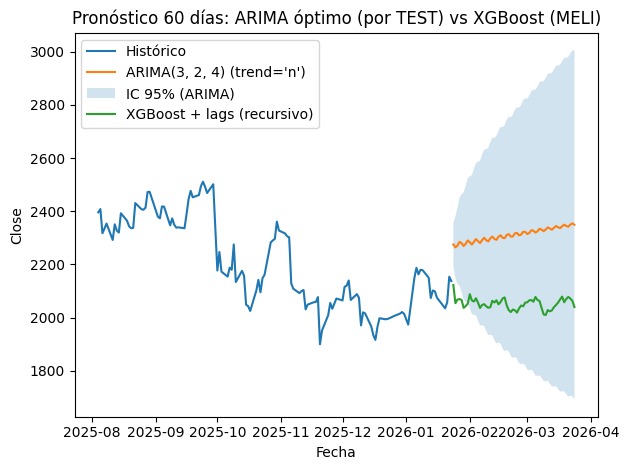

In [9]:

# ========= 8) Gráfico: últimos 120 días + 60 pronósticos =========
lookback = 120 if len(df) > 120 else len(df)
hist_dates = df.index[-lookback:]
hist_vals  = df["Close"].iloc[-lookback:]

plt.figure()
plt.plot(hist_dates, hist_vals, label="Histórico")
plt.plot(future_dates, out_forecast["ARIMA_Forecast"], label=f"ARIMA{best_order} (trend='{best_trend_used}')")
plt.fill_between(future_dates, out_forecast["ARIMA_Lower"], out_forecast["ARIMA_Upper"], alpha=0.2, label="IC 95% (ARIMA)")
plt.plot(future_dates, out_forecast["XGB_Forecast"], label="XGBoost + lags (recursivo)")
plt.title(f"Pronóstico 60 días: ARIMA óptimo (por TEST) vs XGBoost ({ticker})")
plt.xlabel("Fecha"); plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()

## Revisar en Noviembre: IVVPESOISHRS.MX

los precios que predijimos

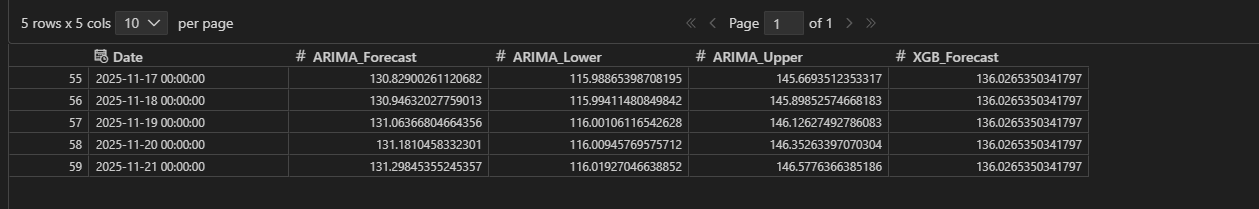

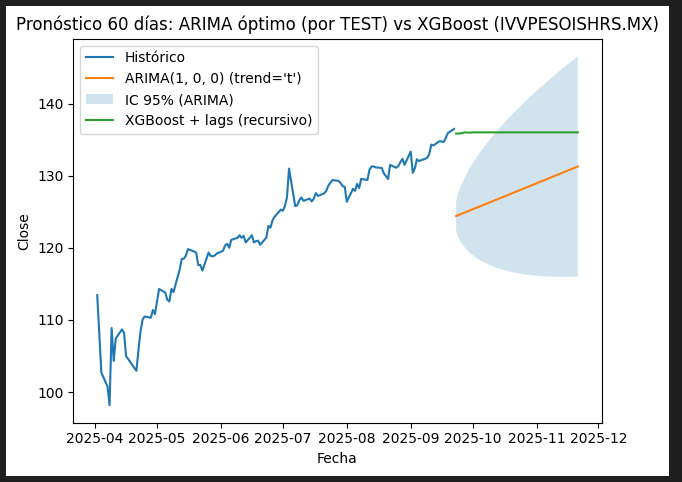